In [30]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
#import tensorflow.contrib.eager as tfe
from functools import partial
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.calibration import calibration_curve
import matplotlib.tri as tri
from scipy.special import betaln
from scipy.stats import beta
from scipy import stats
from scipy.special import gamma as gamma_fun
import scipy.special as spec
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import numpy as np
np.set_printoptions(suppress=True)


from numba import jit

from deep_bayes.models import BayesFlow, SequenceNetwork
from deep_bayes.training import train_online
from deep_bayes.losses import maximum_likelihood_loss
from deep_bayes.viz import plot_true_est_scatter, plot_true_est_posterior

In [31]:
#tf.enable_eager_execution()

In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Forward model priors and generator

Currently, we have the following parameters:

1. $\alpha$ - inverse of incubation period (rate at which exposed move to infected)
2. $\beta$ - average contact rate in the population (I would model this in a more fine-grained manner
3. $\gamma$ - inverse of the mean infectous period (or rate at which infectious move to recovered)
4. $d$ - death rate
5. $\rho$ - social distancing $\in [0, 1]$

In [33]:
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------
    
    Arguments:
    batch_size : int -- the number of samples to draw from the prior
    ----------
    
    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) -- the samples batch of parameters
    """
    

    
    theta = np.random.uniform(low=[0.8, 0.1, 0.1, 0.01], 
                              high=[2.25, 1.0, 0.75, 0.4], size=(batch_size, 4))
    
    return theta


def forward_model(params, t, init_values):
    """Forward model of the SIRD."""
    
    S_0, E_0, I_0, D_0, R_0 = init_vals
    S, E, I, D, R = [S_0], [E_0], [I_0], [D_0], [R_0]
    
    #extract time dependent rhos from params
    rhos = params[0:6]
    rhos_t = params[6:12]
    rhos_t_asi = np.argsort(rhos_t)
    rhos = rhos[rhos_t_asi]
    rhos_t = rhos_t[rhos_t_asi].astype(np.int32)
    
    #construct dense rhos array
    rho = np.ones((t.shape[0]))
    for i in range(rhos_t.shape[0]):
        rho[rhos_t[i]:] = rhos[i]    
    
    beta, alpha, gamma, d = params[12:]
    dt = t[1] - t[0]
    
    for i,_ in enumerate(t[1:]):
        
        next_S = S[-1] + (-rho[i]*beta*S[-1]*I[-1])*dt
        next_E = E[-1] + (rho[i]*beta*S[-1]*I[-1] - alpha*E[-1])*dt
        next_I = I[-1] + (alpha*E[-1] - gamma*I[-1] - d*I[-1])*dt
        next_R = R[-1] + (gamma*I[-1])*dt
        next_D = D[-1] + (d*I[-1])*dt
        
        S.append(next_S)
        E.append(next_E)
        I.append(next_I)
        D.append(next_D)
        R.append(next_R)
    return np.stack([rho, S, I, D, R]).T

N = 10000
init_vals = 1 - 1/N, 1/N, 0, 0, 0
forward_model = partial(forward_model, init_values=init_vals)

In [34]:
def data_generator(batch_size, t_obs=None, t_min=30, t_max=100, dt=1, to_tensor=True, **args):
    """
    Runs the forward model 'batch_size' times by first sampling fromt the prior
    theta ~ p(theta) and running x ~ p(x|theta).
    ----------
    
    Arguments:
    batch_size : int -- the number of samples to draw from the prior
    to_tensor  : boolean -- converts theta and x to tensors if True
    ----------
    
    Output:
    theta : tf.Tensor or np.ndarray of shape (batch_size, theta_dim) - the data gen parameters 
    x     : tf.Tensor of np.ndarray of shape (batch_size, n_obs, x_dim)  - the generated data
    """
    
    # Sample from prior
    # theta is a np.array of shape (batch_size, theta_dim)
    theta = prior(batch_size)
    
    if t_obs is None:
        t_obs = np.random.randint(t_min, t_max+1)
    
    t = np.linspace(0, t_obs, int(t_obs/dt) + 1)
    
    #generate 3x 1.0 rho at timestep 0
    rhos0 = np.ones((batch_size,3))
    rhos_t0 = np.zeros((batch_size,3))
    
    #generate 3 random rhos between 0.1 and 0.9
    rhos = np.random.rand(batch_size,3)
    rhos_t = np.random.randint(t_obs, size=(batch_size,3))
    
    # construct rhoparam matrix
    rhos = np.concatenate([rhos0, rhos],axis=1)
    rhos_t = np.concatenate([rhos_t0, rhos_t],axis=1)
    rhoparams = np.concatenate([rhos,rhos_t],axis=1)
    
    #construct new theta
    thetap = np.concatenate([rhoparams, theta],axis=1)
    
    # Generate data
    # x is a np.ndarray of shape (batch_size, n_obs, x_dim)
    x = np.apply_along_axis(forward_model, axis=1, arr=thetap, t=t, **args)
    
    # Convert to tensor, if specified 
    if to_tensor:
        theta = tf.convert_to_tensor(theta, dtype=tf.float32)
        rhoparams = tf.convert_to_tensor(rhoparams, dtype=tf.float32)
        x = tf.convert_to_tensor(x, dtype=tf.float32)
    return {'theta': theta, 'rhoparams':rhoparams, 'x': x}

# Training hyperparameters

In [35]:
# Network hyperparameters
inv_meta = {
    'n_units': [128, 128, 128],
    'activation': 'elu',
    'w_decay': 0.00001,
    'initializer': 'glorot_uniform'
}
n_inv_blocks = 6


summary_meta = {
    'lstm_units' :  64,
    'conv_meta'  : [
            dict(filters=64, kernel_size=5, strides=1, activation='elu', kernel_initializer='glorot_normal', padding='same'),
            dict(filters=64, kernel_size=3, strides=1, activation='elu', kernel_initializer='glorot_normal', padding='same'),
            dict(filters=64, kernel_size=3, strides=1, activation='elu', kernel_initializer='glorot_normal', padding='same'),
            dict(filters=64, kernel_size=3, strides=1, activation='elu', kernel_initializer='glorot_normal', padding='same'),
            dict(filters=64, kernel_size=3, strides=1, activation='elu', kernel_initializer='glorot_normal', padding='same'),
    ],
}


# Forward model hyperparameters
param_names = [r'$\beta$', r'$\alpha$', r'$\gamma$', r'$d$']
theta_dim = len(param_names)
n_test = 500


# Training and optimizer hyperparameters
ckpt_file = "SEIDR"
batch_size = 64
epochs = 100
iterations_per_epoch = 1000
n_samples_posterior = 2000
clip_value = 5.

starter_learning_rate = 0.0005

#global_step = tfe.Variable(0, dtype=tf.int32)
global_step = tf.Variable(0, dtype=tf.int32)

decay_steps = 1000
decay_rate = .99
learning_rate = tf.compat.v1.train.exponential_decay(starter_learning_rate, global_step, 
                                           decay_steps, decay_rate, staircase=True)
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

data_gen = partial(data_generator, t_min=30, t_max=120)

## Create test data

In [36]:
%%time
test_data = data_gen(n_test, t_obs=100)

CPU times: user 248 ms, sys: 2.53 ms, total: 251 ms
Wall time: 251 ms


## Create networks

In [37]:
summary_net = SequenceNetwork(summary_meta)
model = BayesFlow(inv_meta, n_inv_blocks, theta_dim, summary_net=summary_net, permute=True)

## Compile 
<p>In other words, run and plot performance of untrained networks.</p>

KeyboardInterrupt: 

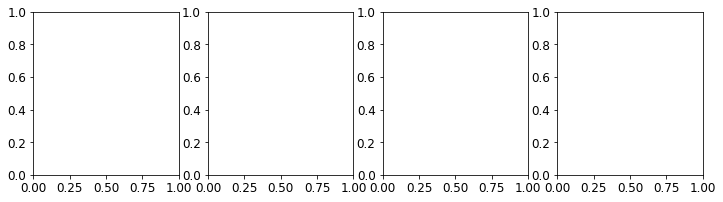

In [38]:
plot_true_est_scatter(model, test_data['x'], test_data['theta'], 
                      n_samples_posterior, param_names, figsize=(12, 3))

## Manage checkpoints

In [ ]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/{}'.format(ckpt_file), max_to_keep=3)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

# Train networks

In [ ]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)

In [ ]:
%%time
for ep in range(1, 10+1):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        losses = train_online(model=model, 
                              optimizer=optimizer, 
                              data_gen=data_generator, 
                              loss_fun=maximum_likelihood_loss, 
                              iterations=iterations_per_epoch,
                              batch_size=batch_size,
                              p_bar=p_bar,
                              clip_value=clip_value,
                              clip_method='value',
                              global_step=global_step)
        
        plot_true_est_scatter(model, test_data['x'], test_data['theta'], 
                      n_samples_posterior, param_names, figsize=(12, 3))
        
        plot_true_est_posterior(model, 2000, param_names, font_size=8,
                        X_test=test_data['x'][:5], 
                        theta_test=test_data['theta'][:5], figsize=(12, 8))

        # Manage checkpoint
        manager.save()

In [ ]:
t_obs = 100
dt = 1    
t = np.linspace(0, t_obs, int(t_obs/dt) + 1)
params = np.array([1.2, 0.75, 0.2, 0.1, 0.6])
ts = forward_model(params, t=t)
labels = ['S', 'I', 'D', 'R']

f, ax = plt.subplots(1, 1, figsize=(15, 10))
for i in range(4):
    ax.plot(ts[:, i], label=labels[i], lw=2)

plt.legend()
ts_t = tf.convert_to_tensor(ts[np.newaxis], dtype=tf.float32)


theta_hat = model.sample(ts_t, 5000, to_numpy=True)

f, axarr = plt.subplots(1, 5, figsize=(12, 3))
for i in range(5):
    
    sns.distplot(theta_hat[:, i], ax=axarr[i], kde=False)
    axarr[i].axvline(params[i], color='black')
    
f.tight_layout()

In [ ]:
t_obs = 30
dt = 1    
t = np.linspace(0, t_obs, int(t_obs/dt) + 1)
params = np.array([1.2, 0.75, 0.2, 0.1, 0.99])
ts = forward_model(params, t=t)
labels = ['S', 'I', 'D', 'R']

f, ax = plt.subplots(1, 1, figsize=(15, 10))
for i in range(4):
    ax.plot(ts[:, i], label=labels[i], lw=2)

plt.legend()
ts_t = tf.convert_to_tensor(ts[np.newaxis], dtype=tf.float32)


theta_hat = model.sample(ts_t, 5000, to_numpy=True)

f, axarr = plt.subplots(1, 5, figsize=(12, 3))
for i in range(5):
    
    sns.distplot(theta_hat[:, i], ax=axarr[i], kde=False)
    axarr[i].axvline(params[i], color='black')
    
f.tight_layout()

In [ ]:
params

In [ ]:
theta_hat.mean(0)